#**Image Colorization Through Conditional WGAN**

In [ ]:
!pip install torchsummary

In [ ]:
import os
from pathlib import Path
import glob
import gc 
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import PIL
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import pytorch_lightning as pl
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy
from torchsummary import summary
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
ab_path = "ab/ab1.npy"
l_path = "l/gray_scale.npy"

In [ ]:
ab_df = np.load(ab_path)[0:5000]
L_df = np.load(l_path)[0:5000]
dataset = (L_df,ab_df )
gc.collect()

38994

In [ ]:
def lab_to_rgb(L, ab):
    """
    Takes an image or a batch of images and converts from LAB space to RGB
    """
    L = L  * 100
    ab = (ab - 0.5) * 128 * 2
    Lab = torch.cat([L, ab], dim=2).numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

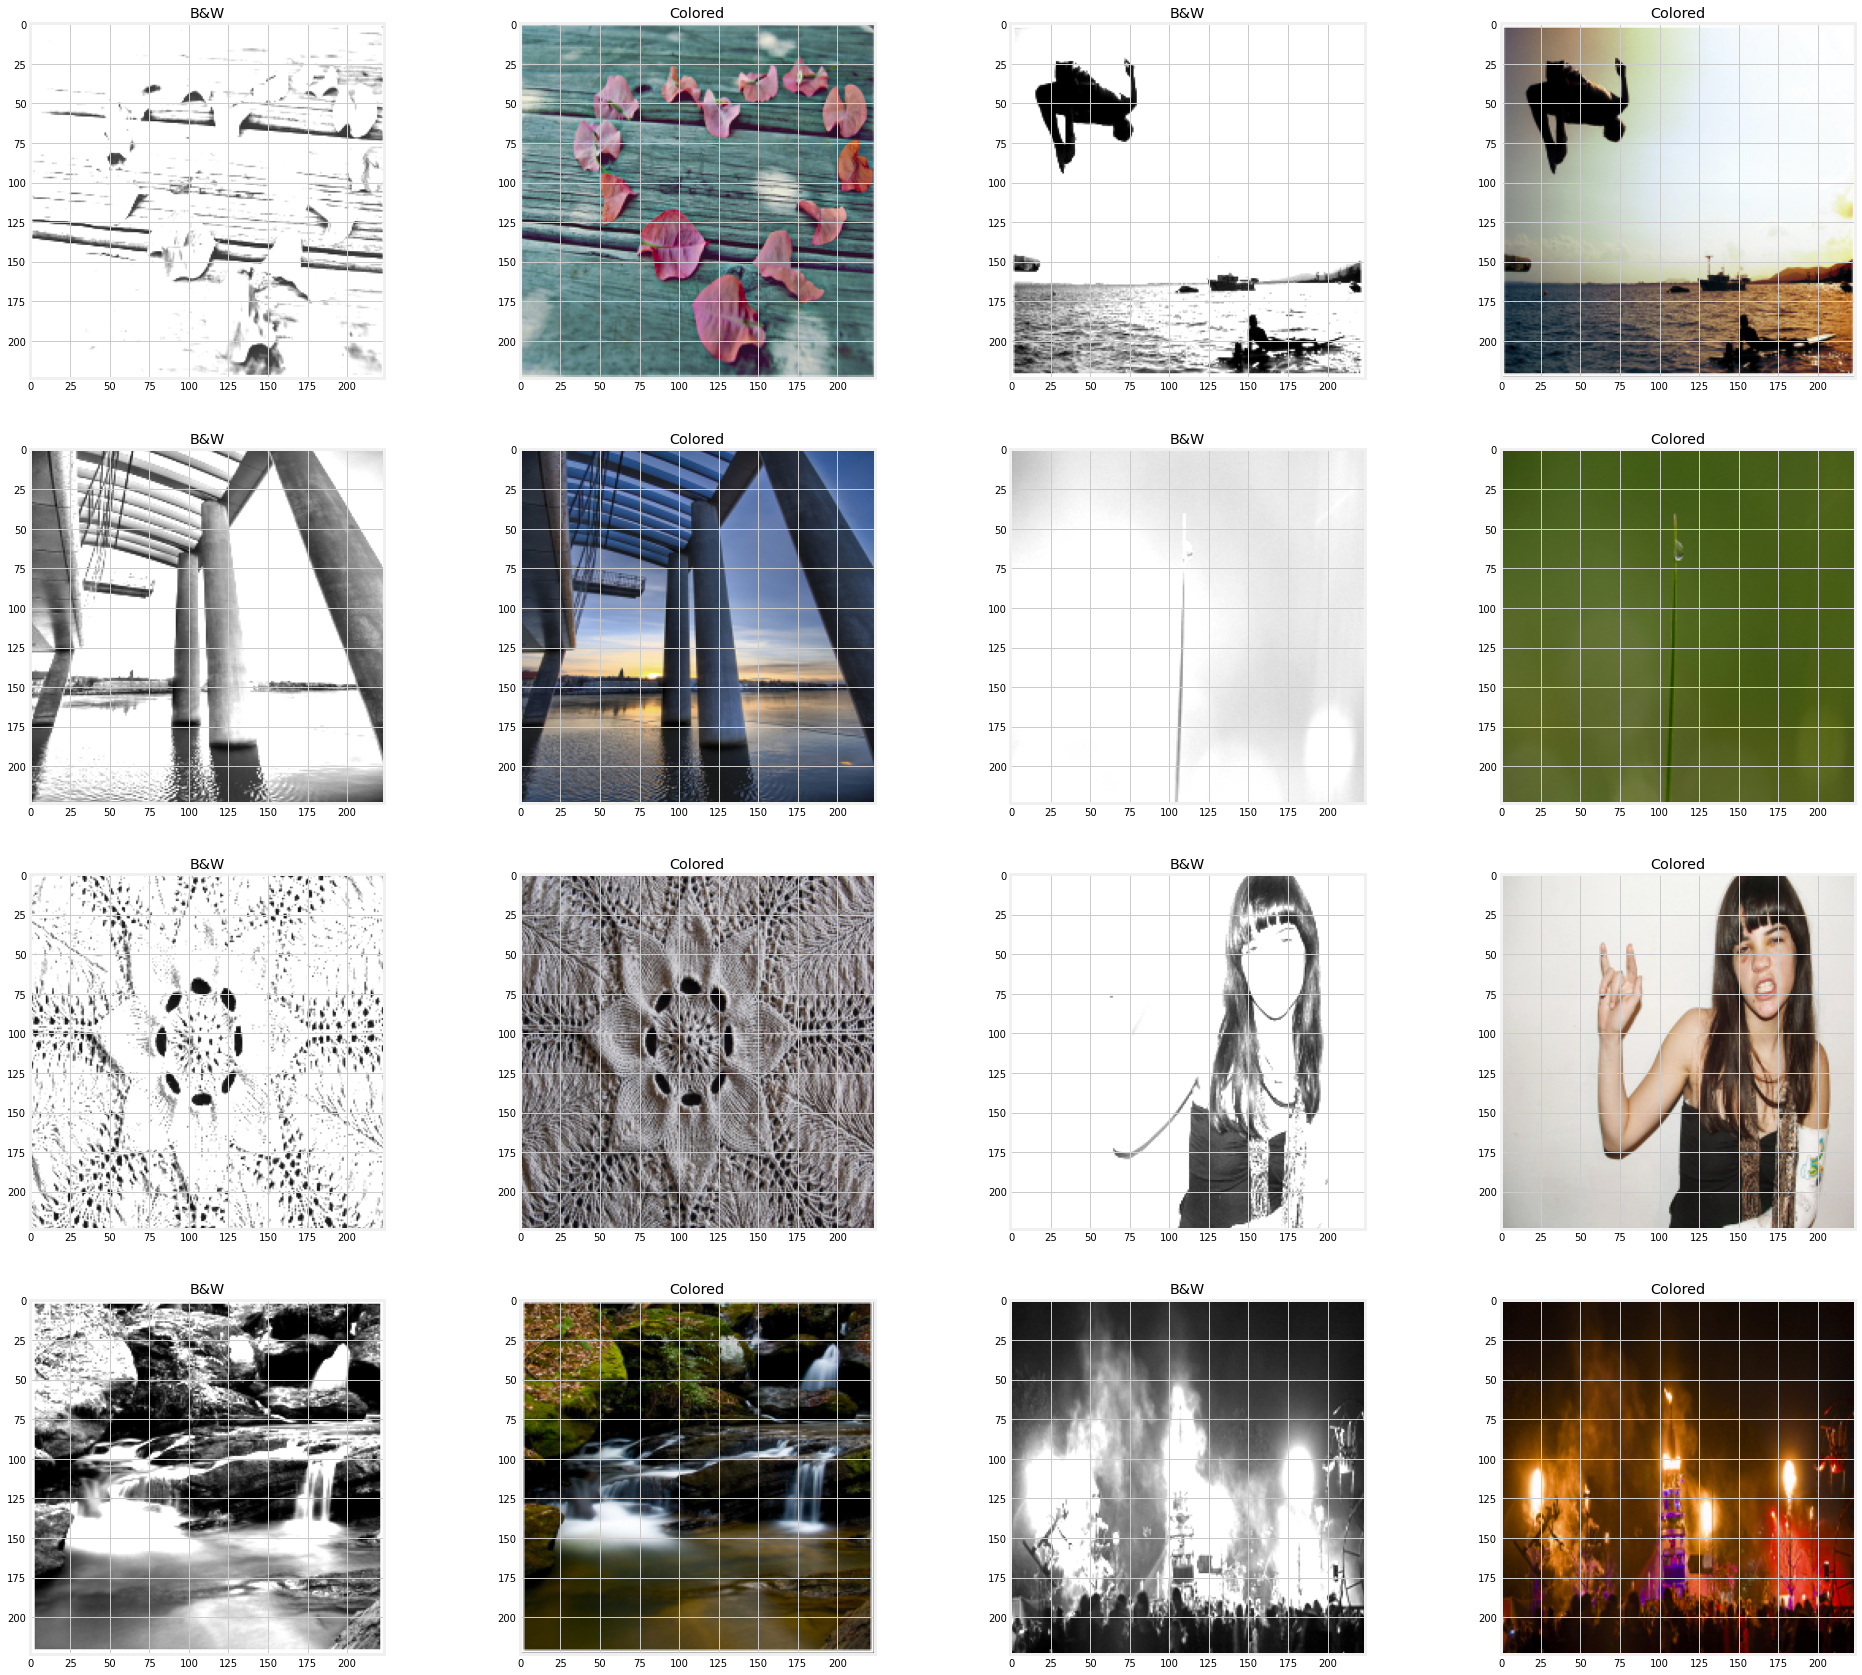

In [ ]:
plt.figure(figsize=(30,30))
for i in range(1,16,2):
    plt.subplot(4,4,i)
    img = np.zeros((224,224,3))
    img[:,:,0] = L_df[i]
    plt.title('B&W')
    plt.imshow(lab2rgb(img))
    
    plt.subplot(4,4,i+1)
    img[:,:,1:] = ab_df[i]
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    plt.title('Colored')
    plt.imshow(img)

In [ ]:
gc.collect()

52660

In [ ]:
class ImageColorizationDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset[0])
    
    def __getitem__(self, idx):
        L = np.array(dataset[0][idx]).reshape((224,224,1))
        L = transforms.ToTensor()(L)
        
        ab = np.array(dataset[1][idx])
        ab = transforms.ToTensor()(ab)

        return ab, L

In [ ]:
batch_size = 1

train_dataset = ImageColorizationDataset(dataset = (L_df, ab_df))
test_dataset = ImageColorizationDataset(dataset = (L_df, ab_df))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True, pin_memory = True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle = False, pin_memory = True)

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,kernel_size=3,padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.identity_map = nn.Conv2d(in_channels, out_channels,kernel_size=1,stride=stride)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, inputs):
        x = inputs.clone().detach()
        out = self.layer(x)
        residual  = self.identity_map(inputs)
        skip = out + residual
        return self.relu(skip)

In [ ]:
class DownSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.layer = nn.Sequential(
            nn.MaxPool2d(2),
            ResBlock(in_channels, out_channels)
        )

    def forward(self, inputs):
        return self.layer(inputs)

In [ ]:
class UpSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.res_block = ResBlock(in_channels + out_channels, out_channels)
        
    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        x = torch.cat([x, skip], dim=1)
        x = self.res_block(x)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_channel, output_channel, dropout_rate = 0.2):
        super().__init__()
        self.encoding_layer1_ = ResBlock(input_channel,64)
        self.encoding_layer2_ = DownSampleConv(64, 128)
        self.encoding_layer3_ = DownSampleConv(128, 256)
        self.bridge = DownSampleConv(256, 512)
        self.decoding_layer3_ = UpSampleConv(512, 256)
        self.decoding_layer2_ = UpSampleConv(256, 128)
        self.decoding_layer1_ = UpSampleConv(128, 64)
        self.output = nn.Conv2d(64, output_channel, kernel_size=1)
        self.dropout = nn.Dropout2d(dropout_rate)
        
    def forward(self, inputs):
        e1 = self.encoding_layer1_(inputs)
        e1 = self.dropout(e1)
        e2 = self.encoding_layer2_(e1)
        e2 = self.dropout(e2)
        e3 = self.encoding_layer3_(e2)
        e3 = self.dropout(e3)
  
        bridge = self.bridge(e3)
        bridge = self.dropout(bridge)
        
        d3 = self.decoding_layer3_(bridge, e3)
        d2 = self.decoding_layer2_(d3, e2)
        d1 = self.decoding_layer1_(d2, e1)
        
        output = self.output(d1)
        return output

In [ ]:
model = Generator(1,2).to(device)
summary(model, (1, 224, 224), batch_size = 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]             576
       BatchNorm2d-2          [1, 64, 224, 224]             128
              ReLU-3          [1, 64, 224, 224]               0
            Conv2d-4          [1, 64, 224, 224]          36,864
       BatchNorm2d-5          [1, 64, 224, 224]             128
              ReLU-6          [1, 64, 224, 224]               0
            Conv2d-7          [1, 64, 224, 224]             128
              ReLU-8          [1, 64, 224, 224]               0
          ResBlock-9          [1, 64, 224, 224]               0
        Dropout2d-10          [1, 64, 224, 224]               0
        MaxPool2d-11          [1, 64, 112, 112]               0
           Conv2d-12         [1, 128, 112, 112]          73,728
      BatchNorm2d-13         [1, 128, 112, 112]             256
             ReLU-14         [1, 128, 1

In [ ]:
class Critic(nn.Module):
    def __init__(self, in_channels=3):
        super(Critic, self).__init__()

        def critic_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *critic_block(in_channels, 64, normalization=False),
            *critic_block(64, 128),
            *critic_block(128, 256),
            *critic_block(256, 512),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, ab, l):
        img_input = torch.cat((ab, l), 1)
        output = self.model(img_input)
        return output

In [ ]:
model = Critic(3).to(device)
summary(model, [(2, 224, 224), (1, 224, 224)], batch_size = 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 112, 112]           3,136
         LeakyReLU-2          [1, 64, 112, 112]               0
            Conv2d-3           [1, 128, 56, 56]         131,200
    InstanceNorm2d-4           [1, 128, 56, 56]               0
         LeakyReLU-5           [1, 128, 56, 56]               0
            Conv2d-6           [1, 256, 28, 28]         524,544
    InstanceNorm2d-7           [1, 256, 28, 28]               0
         LeakyReLU-8           [1, 256, 28, 28]               0
            Conv2d-9           [1, 512, 14, 14]       2,097,664
   InstanceNorm2d-10           [1, 512, 14, 14]               0
        LeakyReLU-11           [1, 512, 14, 14]               0
AdaptiveAvgPool2d-12             [1, 512, 1, 1]               0
          Flatten-13                   [1, 512]               0
           Linear-14                   

In [ ]:
def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
def display_progress(cond, real, fake, current_epoch = 0, figsize=(20,15)):
    cond = cond.detach().cpu().permute(1, 2, 0)   
    real = real.detach().cpu().permute(1, 2, 0)
    fake = fake.detach().cpu().permute(1, 2, 0)
    
    images = [cond, real, fake]
    titles = ['input','real','generated']
    print(f'Epoch: {current_epoch}')
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    for idx,img in enumerate(images):
        if idx == 0:
            ab = torch.zeros((224,224,2))
            img = torch.cat([images[0]* 100, ab], dim=2).numpy()
            imgan = lab2rgb(img)
        else:
            imgan = lab_to_rgb(images[0],img)
        ax[idx].imshow(imgan)
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
    #plt.show()

In [ ]:
class CWGAN(pl.LightningModule):

    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=100, display_step=10, lambda_gp=10, lambda_r1=10,):

        super().__init__()
        self.save_hyperparameters()
        
        self.display_step = display_step
        
        self.generator = Generator(in_channels, out_channels)
        self.critic = Critic(in_channels + out_channels)
        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
        self.optimizer_C = optim.Adam(self.critic.parameters(), lr=learning_rate, betas=(0.5, 0.9))
        self.lambda_recon = lambda_recon
        self.lambda_gp = lambda_gp
        self.lambda_r1 = lambda_r1
        self.recon_criterion = nn.L1Loss()
        self.generator_losses, self.critic_losses  =[],[]
    
    def configure_optimizers(self):
        return [self.optimizer_C, self.optimizer_G]
        
    def generator_step(self, real_images, conditioned_images):
        self.optimizer_G.zero_grad()
        fake_images = self.generator(conditioned_images)
        recon_loss = self.recon_criterion(fake_images, real_images)
        recon_loss.backward()
        self.optimizer_G.step()
        self.generator_losses += [recon_loss.item()]
        
        
    def critic_step(self, real_images, conditioned_images):
        self.optimizer_C.zero_grad()
        fake_images = self.generator(conditioned_images)
        fake_logits = self.critic(fake_images, conditioned_images)
        real_logits = self.critic(real_images, conditioned_images)
        loss_C = real_logits.mean() - fake_logits.mean()
        alpha = torch.rand(real_images.size(0), 1, 1, 1, requires_grad=True)
        alpha = alpha.to(device)
        interpolated = (alpha * real_images + (1 - alpha) * fake_images.detach()).requires_grad_(True)
        interpolated_logits = self.critic(interpolated, conditioned_images)
        
        grad_outputs = torch.ones_like(interpolated_logits, dtype=torch.float32, requires_grad=True)
        gradients = torch.autograd.grad(outputs=interpolated_logits, inputs=interpolated, grad_outputs=grad_outputs,create_graph=True, retain_graph=True)[0]
        gradients = gradients.view(len(gradients), -1)
        gradients_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        loss_C += self.lambda_gp * gradients_penalty
        
      
        r1_reg = gradients.pow(2).sum(1).mean()
        loss_C += self.lambda_r1 * r1_reg

        loss_C.backward() #BACKPROPAGATION
        self.optimizer_C.step()
        self.critic_losses += [loss_C.item()]
        
    def training_step(self, batch, batch_idx, optimizer_idx):
        real, condition = batch
        if optimizer_idx == 0:
            self.critic_step(real, condition)
        elif optimizer_idx == 1:
            self.generator_step(real, condition)
        gen_mean = sum(self.generator_losses[-self.display_step:]) / self.display_step
        crit_mean = sum(self.critic_losses[-self.display_step:]) / self.display_step
        if self.current_epoch%self.display_step==0 and batch_idx==0 and optimizer_idx==1:
            fake = self.generator(condition).detach()
            torch.save(cwgan.generator.state_dict(), "ResUnet_"+ str(self.current_epoch) +".pt")
            torch.save(cwgan.critic.state_dict(), "PatchGAN_"+ str(self.current_epoch) +".pt")
            print(f"Epoch {self.current_epoch} : Generator loss: {gen_mean}, Critic loss: {crit_mean}")
            display_progress(condition[0], real[0], fake[0], self.current_epoch)


In [ ]:
gc.collect()
cwgan = CWGAN(in_channels = 1, out_channels = 2 ,learning_rate=2e-4, lambda_recon=100, display_step=10)

Training: 0it [00:00, ?it/s]

Epoch 0 : Generator loss: 0.03247362431138754, Critic loss: 1.8929198622703551
Epoch: 0


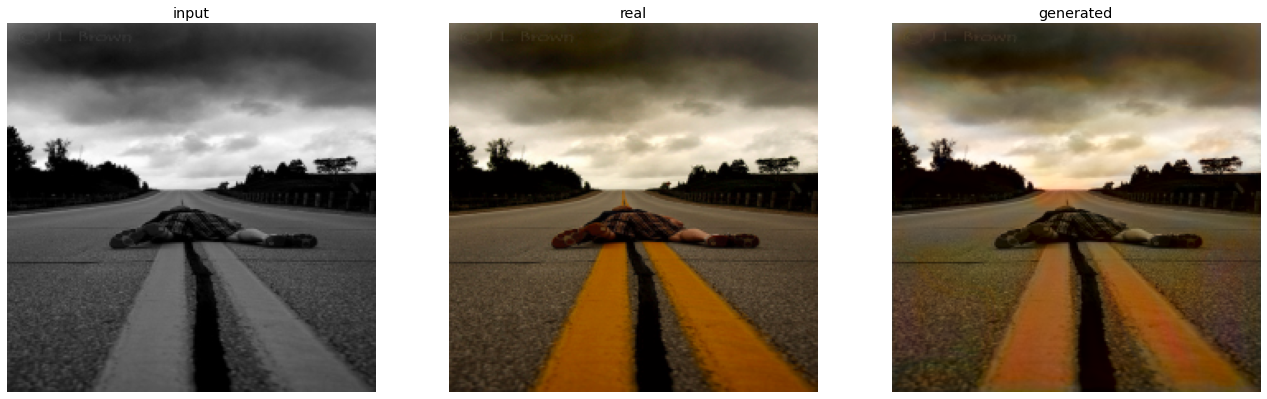

Epoch 20 : Generator loss: 0.030137248756363987, Critic loss: 1.6823475003242492
Epoch: 20


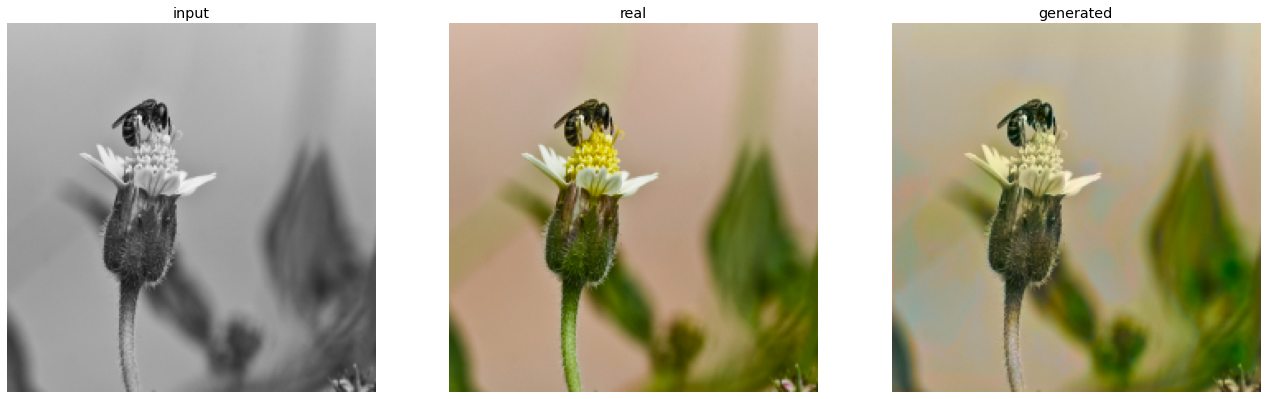

Epoch 40 : Generator loss: 0.030648819264024497, Critic loss: 2.719594693183899
Epoch: 40


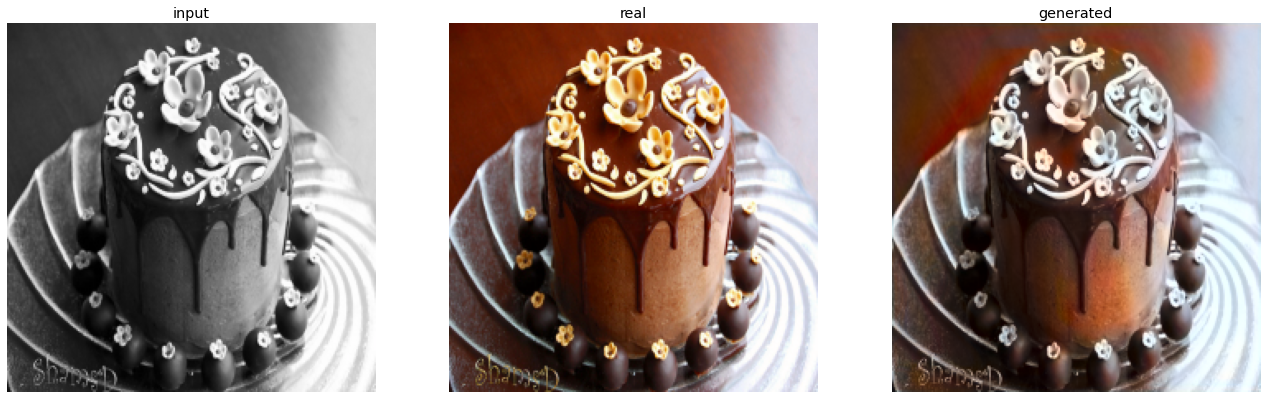

Epoch 60 : Generator loss: 0.02684174436144531, Critic loss: 2.2832462310791017
Epoch: 60


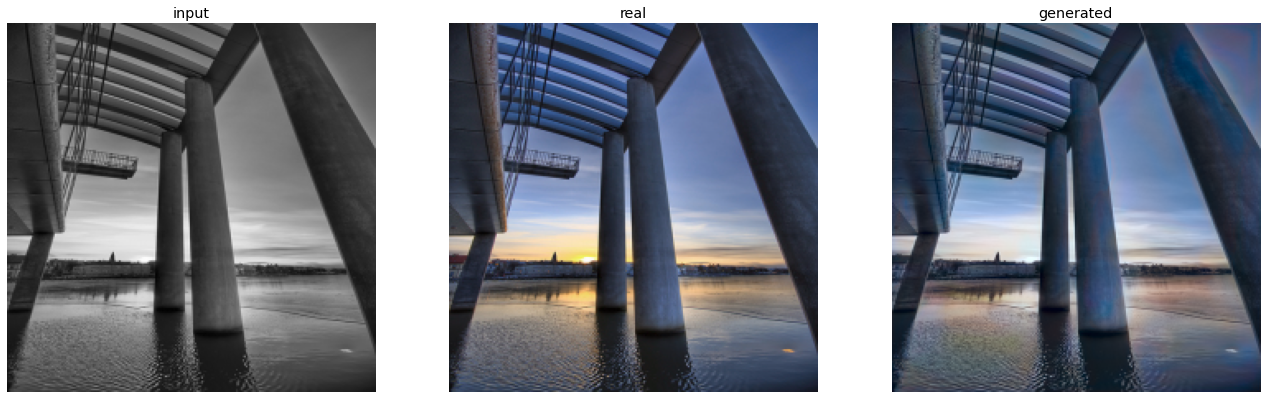

Epoch 80 : Generator loss: 0.02874268852174282, Critic loss: 2.65061115026474
Epoch: 80


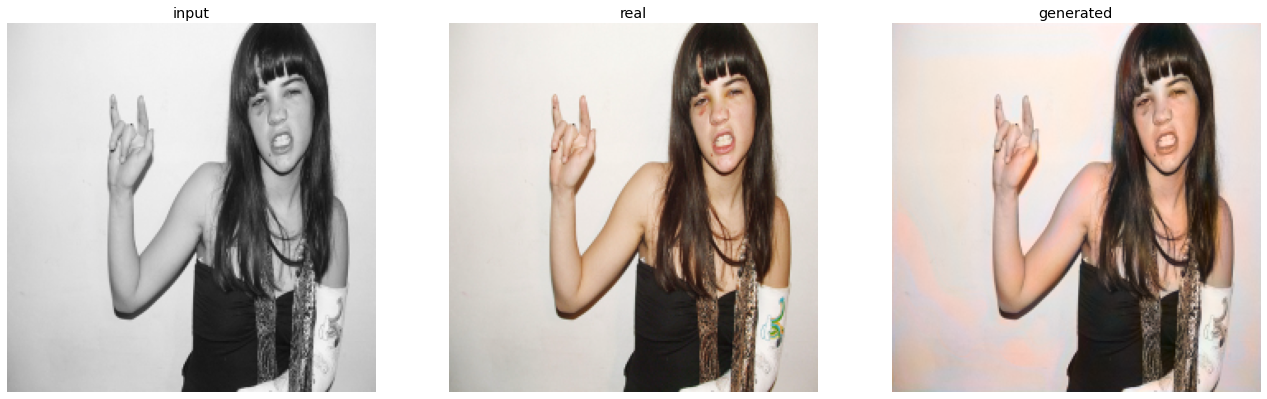

In [ ]:
trainer = pl.Trainer(max_epochs=150, gpus=-1)
trainer.fit(cwgan, train_loader)